In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

from scipy import stats
from scipy.stats import norm, skew # for some statistics
import warnings # to ignore warning
from sklearn.preprocessing import RobustScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import joblib

import warnings
warnings.filterwarnings('ignore')
print("Library Imported!!")

Library Imported!!


In [5]:
# load train and test dataset
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
     

In [6]:
train_df.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [7]:
train_df.shape

(14999, 9)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   vidid      14999 non-null  object
 1   adview     14999 non-null  int64 
 2   views      14999 non-null  object
 3   likes      14999 non-null  object
 4   dislikes   14999 non-null  object
 5   comment    14999 non-null  object
 6   published  14999 non-null  object
 7   duration   14999 non-null  object
 8   category   14999 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB


In [9]:
train_df.describe(include='all')

,vidid,adview,views,likes,dislikes,comment,published,duration,category
count,14999,1.499900e+04,14999,14999,14999,14999,14999,14999,14999
unique,14999,NaN,14588,4789,1546,2007,2386,3146,8
top,VID_18655,NaN,885,1,0,0,2016-08-26,PT31S,D
freq,1,NaN,4,174,1091,1290,42,147,7558
mean,NaN,2.107791e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,5.237711e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,6.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train_dtype = train_df.dtypes
train_dtype.value_counts()

object    8
int64     1
Name: count, dtype: int64

In [11]:
train_df.isnull().sum()

vidid        0
adview       0
views        0
likes        0
dislikes     0
comment      0
published    0
duration     0
category     0
dtype: int64

<Axes: >

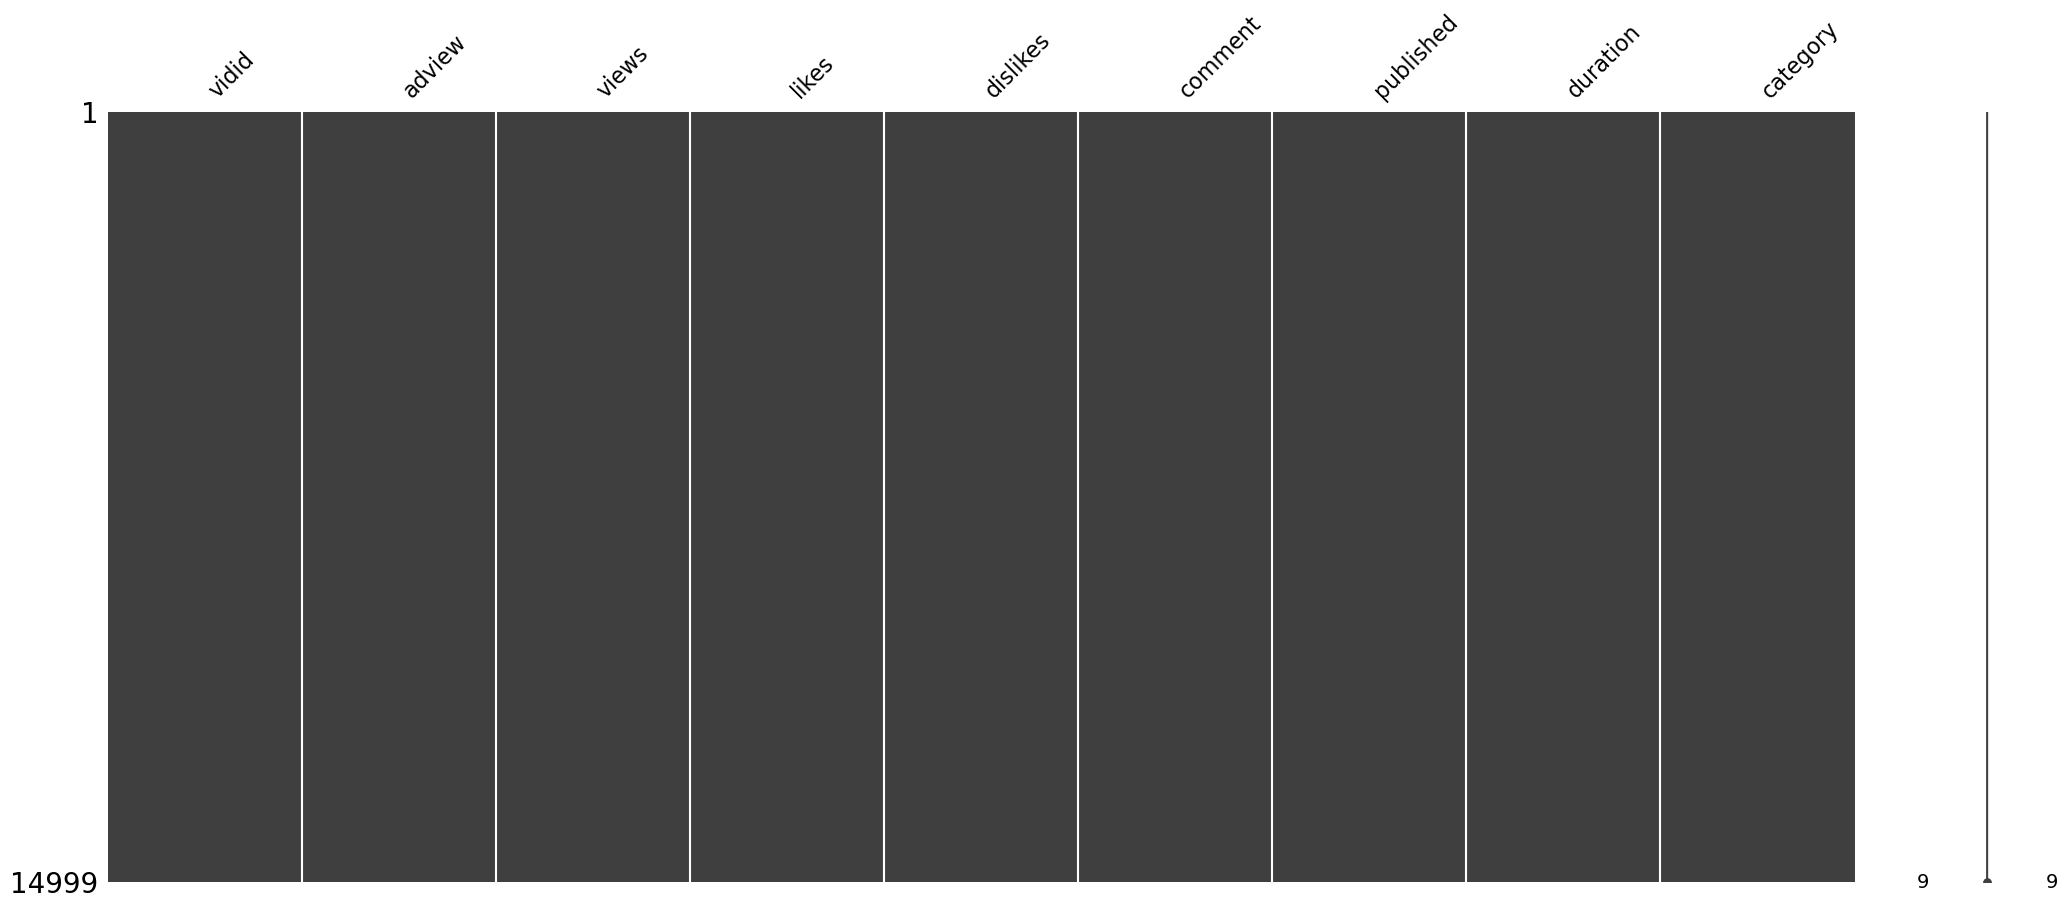

In [12]:
msno.matrix(train_df)

In [13]:
test_df.head()

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_1054,440238,6153,218,1377,2017-02-18,PT7M29S,B
1,VID_18629,1040132,8171,340,1047,2016-06-28,PT6M29S,F
2,VID_13967,28534,31,11,1,2014-03-10,PT37M54S,D
3,VID_19442,1316715,2284,250,274,2010-06-05,PT9M55S,G
4,VID_770,1893173,2519,225,116,2016-09-03,PT3M8S,B


In [14]:

test_dtype = test_df.dtypes
test_dtype.value_counts()

object    8
Name: count, dtype: int64

In [15]:
test_df.describe(include='all')

,vidid,views,likes,dislikes,comment,published,duration,category
count,8764,8764,8764,8764,8764,8764,8764,8764
unique,8764,8605,3434,1215,1556,2109,2330,8
top,VID_1054,688,2,0,0,2016-08-26,PT31S,D
freq,1,3,89,662,727,32,120,4419


In [16]:
test_df.isnull().sum()

vidid        0
views        0
likes        0
dislikes     0
comment      0
published    0
duration     0
category     0
dtype: int64

In [18]:
trn_dtype = train_dtype.drop('adview')
trn_dtype.compare(test_dtype)

,self,other


In [19]:
null_train = train_df.isnull().sum()
null_test = test_df.isnull().sum()
null_train = null_train.drop('adview')
null_comp_df = null_train.compare(null_test).sort_values(['self'],ascending = [False])
null_comp_df 

,self,other


In [20]:
convert_col = ['views', 'likes', 'dislikes', 'comment']
# these columns contain 'F' letter. So replace it by '0'. As we are converting columns to numerical.
for col in convert_col:
  train_df[col].replace({"F": 0}, inplace=True)
  test_df[col].replace({"F": 0}, inplace=True)


# Convert "categorical" feature to "numerical"
for col in convert_col:
  train_df[col] = train_df[col].astype('int')
  test_df[col] = test_df[col].astype('int')

In [21]:
train_df.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [22]:
# convert "duration" column format into "second" format
def checki(x):
    y = x[2:]
    h = ''
    m = ''
    s = ''
    mm = ''
    P = ['H','M','S']
    for i in y:
        if i not in P:
            mm+=i
        else:
            if(i=="H"):
                h = mm
                mm = ''
            elif(i == "M"):
                m = mm
                mm = ''
            else:
                s = mm
                mm = ''
    if(h==''):
        h = '00'
    if(m == ''):
        m = '00'
    if(s==''):
        s='00'
    bp = h+':'+m+':'+s
    return bp

train_mp = train_df["duration"]
test_mp = test_df["duration"]

train_time = train_mp.apply(checki)
test_time = test_mp.apply(checki)

def func_sec(time_string):
    h, m, s = time_string.split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)

train_time=train_time.apply(func_sec)
test_time=test_time.apply(func_sec)

train_df["duration"]=train_time
test_df["duration"]=test_time
# train_df.head()

In [23]:
train_df['published'] = pd.DatetimeIndex(train_df['published']).year
test_df['published'] = pd.DatetimeIndex(test_df['published']).year

# convert to numerical feature
train_df['published'] = train_df['published'].astype('int')
test_df['published'] = test_df['published'].astype('int')

In [24]:
train_df.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016,457,F
1,VID_14135,2,1707,56,2,6,2016,570,D
2,VID_2187,1,2023,25,0,2,2016,136,C
3,VID_23096,6,620860,777,161,153,2016,262,H
4,VID_10175,1,666,1,0,0,2016,31,D


In [25]:
numerical_features = [col for col in train_df.columns if train_df[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(train_df[col].unique()) < 10 and col not in ['vidid']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['vidid']]
categorical_features = [col for col in train_df.columns if train_df[col].dtype == 'O']

print("Total Number of Numerical Columns : ",len(numerical_features))
print("Number of discrete features : ",len(discrete_features))
print("No of continuous features are : ", len(continuous_features))
print("Number of categorical features : ",len(categorical_features))

Total Number of Numerical Columns :  7
Number of discrete features :  0
No of continuous features are :  7
Number of categorical features :  2


In [26]:
# combined train and test datasets
combined_df = pd.concat([train_df,test_df],axis=0)

combined_df["Label"] = "test"
combined_df["Label"][:14999] = "train"

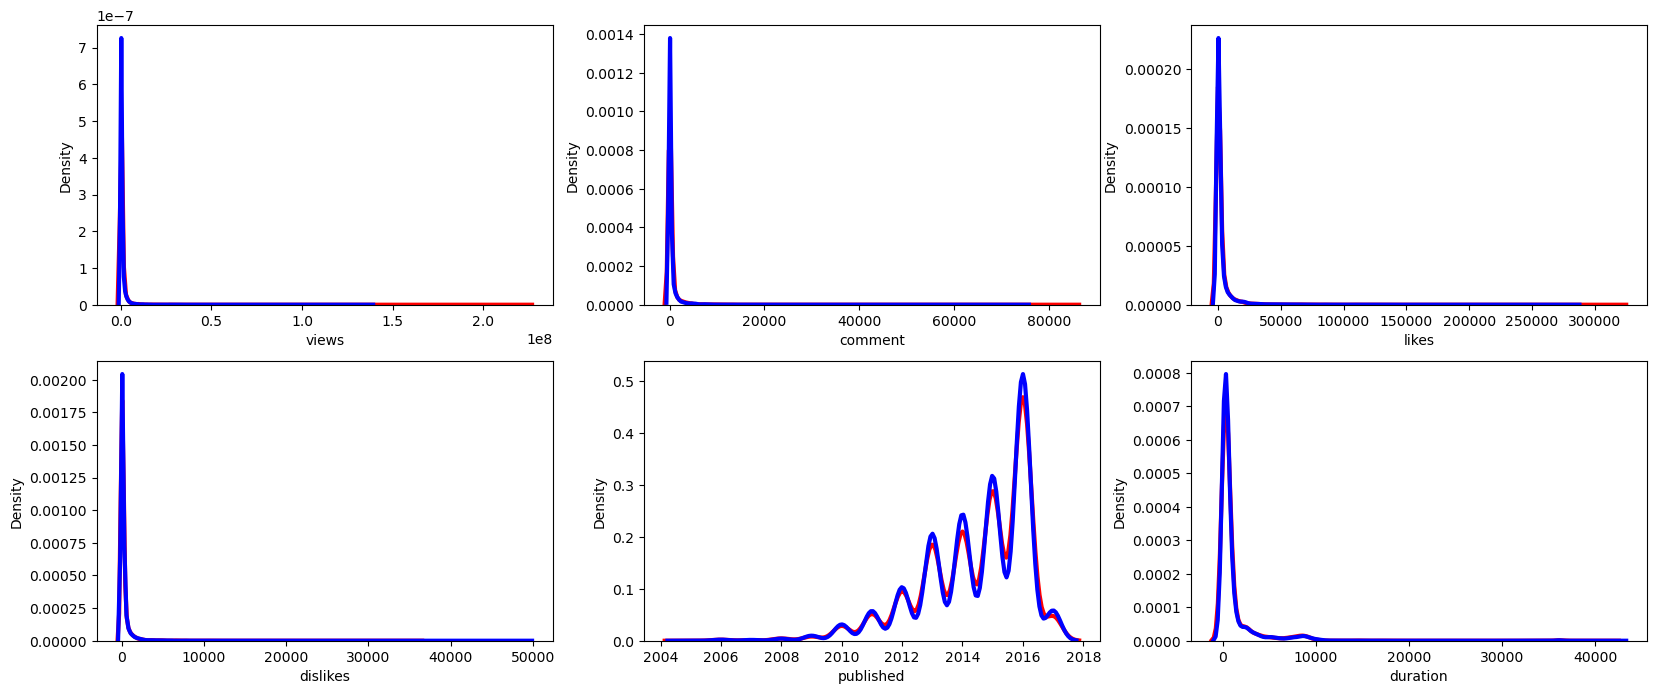

In [27]:
plt.figure(figsize=(20, 8))
continuous_features = ['views', 'comment', 'likes', 'dislikes','published', 'duration']
pos = 1
for i, feature in enumerate(continuous_features):
  plt.subplot(2 , 3 , pos)
  sns.distplot(test_df[feature], hist = False, kde = True, kde_kws = {'linewidth': 3},color='r' )
  sns.distplot(train_df[feature], hist = False, kde = True, kde_kws = {'linewidth': 3} ,color='b')
  pos = pos + 1


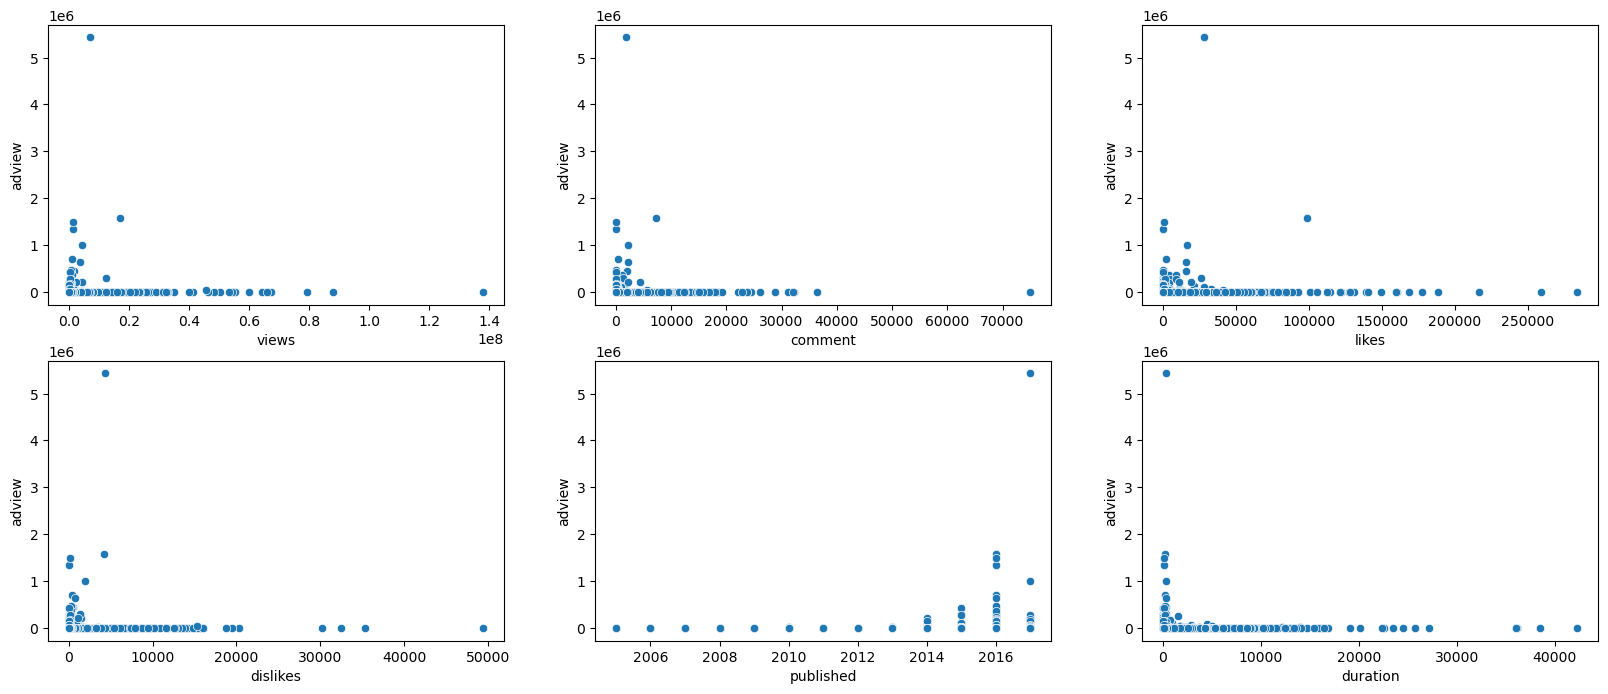

In [28]:
plt.figure(figsize=(20, 8))
pos = 1
for i, feature in enumerate(continuous_features):
  plt.subplot(2 , 3 , pos)
  sns.scatterplot(data=combined_df, x = feature, y= "adview")
  pos = pos + 1

<Axes: xlabel='category', ylabel='count'>

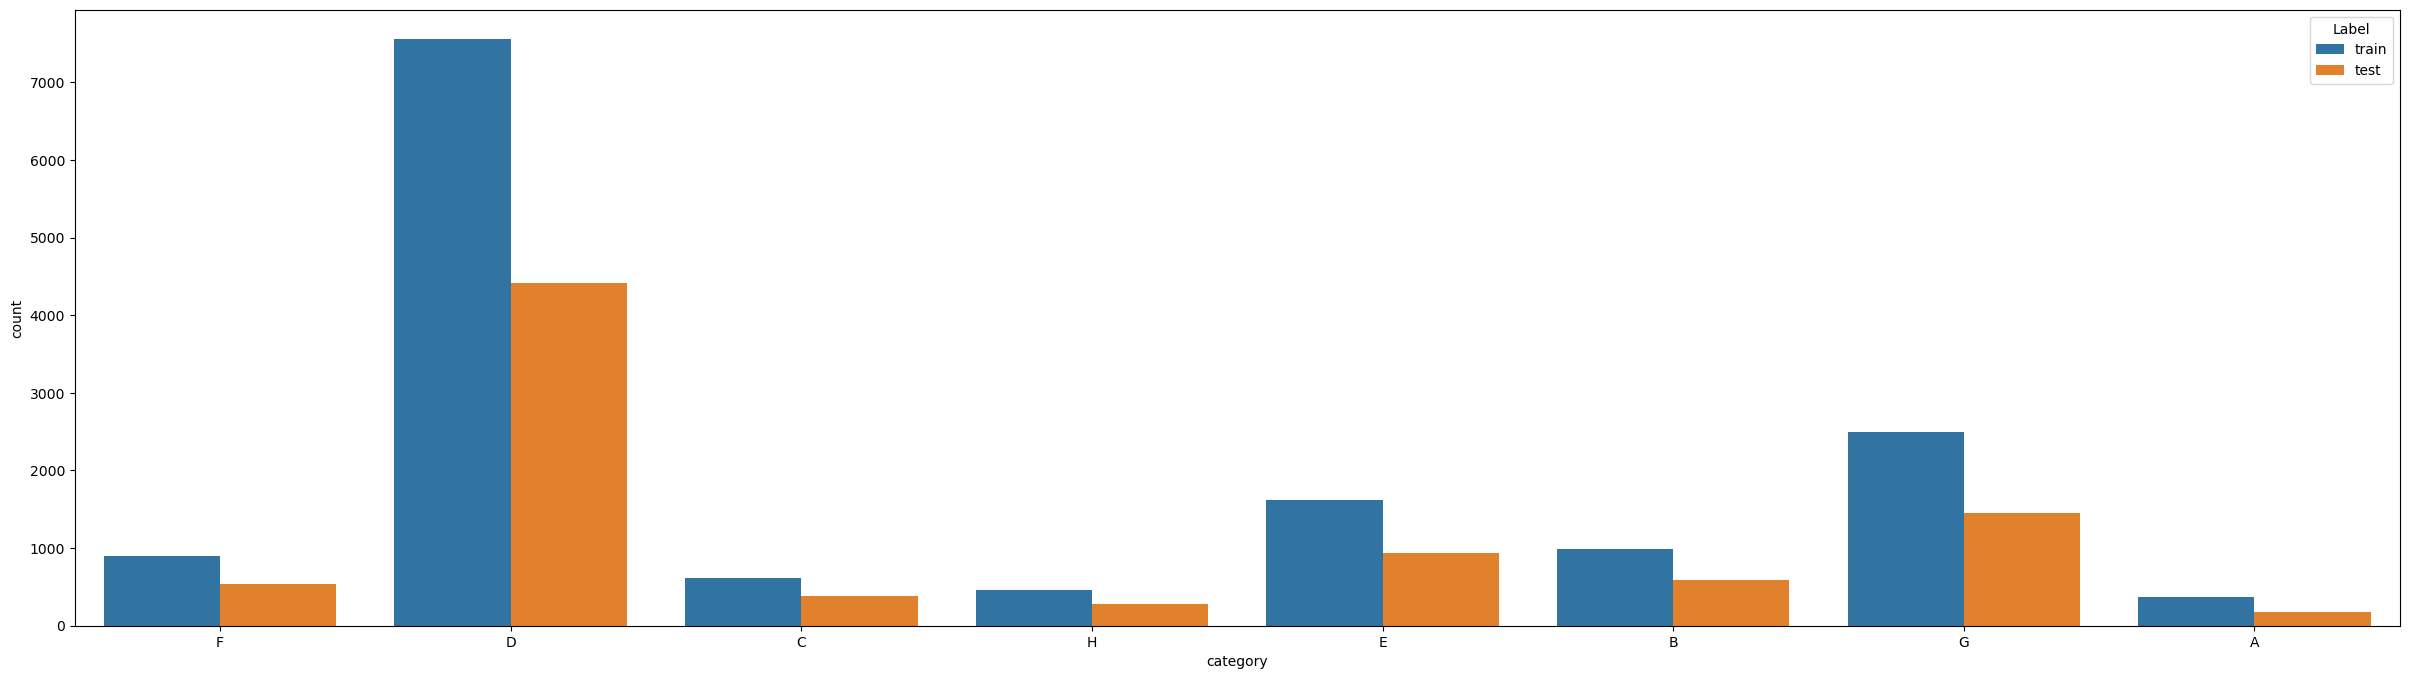

In [29]:
plt.figure(figsize=(30, 8))
sns.countplot(data = combined_df, x = 'category', hue="Label")

<Axes: xlabel='adview', ylabel='Density'>

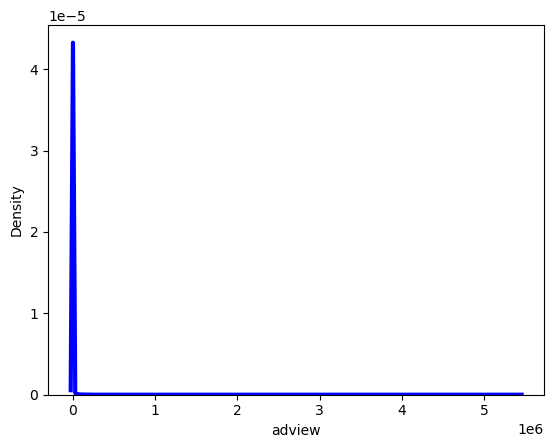

In [30]:
sns.distplot(train_df["adview"], hist = False, kde = True, kde_kws = {'linewidth': 3} ,color='b')

training_corr = train_df.corr(method='spearman') 
plt.figure(figsize=(20,10))
sns.heatmap(training_corr,cmap="YlGnBu", linewidths=.5)

In [33]:
drop_columns = ["vidid",'Label','published','duration']

#  Drop columns
print("Number of columns before dropping : ",len(combined_df.columns))
print("Number of dropping columns : ",len(drop_columns))
combined_df.drop(columns=drop_columns, inplace=True, errors='ignore')
print("Number of columns after dropping : ",len(combined_df.columns))

Number of columns before dropping :  10
Number of dropping columns :  4
Number of columns after dropping :  6


In [34]:
# check the skew of all numerical features
skew_check_col = ['views','likes','dislikes','comment']
skewed_feats = combined_df[skew_check_col].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
print('\n Skew in numberical features: \n')
skewness_df = pd.DataFrame({'Skew' : skewed_feats})
print(skewness_df.head(7))


 Skew in numberical features: 

               Skew
views     29.926939
comment   18.761969
dislikes  18.269315
likes     11.914098


In [35]:
for col in skew_check_col:
  power = PowerTransformer(method='yeo-johnson', standardize=True)
  combined_df[[col]] = power.fit_transform(combined_df[[col]]) # fit with combined_data to avoid overfitting with training data

print('Number of skewed numerical features got transform : ', len(skew_check_col))

Number of skewed numerical features got transform :  4


In [36]:
# Generate one-hot dummy columns
combined_df = pd.get_dummies(combined_df).reset_index(drop=True)

In [37]:
combined_df.head()

,adview,views,likes,dislikes,comment,category_A,category_B,category_C,category_D,category_E,category_F,category_G,category_H
0,40.0,1.000244,1.441680,1.103359,1.398827,False,False,False,False,False,True,False,False
1,2.0,-1.693941,-0.819659,-1.200594,-0.781064,False,False,False,True,False,False,False,False
2,1.0,-1.641413,-1.119185,-1.747128,-1.168045,False,False,True,False,False,False,False,False
3,6.0,0.722749,0.280058,0.723964,0.577704,False,False,False,False,False,False,False,True
4,1.0,-1.970231,-2.009511,-1.747128,-1.679421,False,False,False,True,False,False,False,False


In [38]:
new_train_data = combined_df.iloc[:len(train_df), :]
new_test_data = combined_df.iloc[len(train_df):, :]
X_train = new_train_data.drop('adview', axis=1)
y_train = np.log1p(new_train_data['adview'].values.ravel())
X_test = new_test_data.drop('adview', axis=1)

In [39]:
# Make Pipeline
pre_precessing_pipeline = make_pipeline(RobustScaler())

X_train = pre_precessing_pipeline.fit_transform(X_train)
X_test = pre_precessing_pipeline.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(14999, 12)
(8764, 12)


In [40]:
RANDOM_SEED = 23

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
     

In [41]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

In [42]:
def ridge_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.1, 20)

    ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        ridge,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# ridge_params = tune(ridge_objective)


# Best score: -1.898690687982798 
ridge_params = {'alpha': 19.99855836300504}

In [43]:
ridge = Ridge(**ridge_params, random_state=RANDOM_SEED)
ridge.fit(X_train,y_train)

Ridge(alpha=19.99855836300504, random_state=23)

In [44]:
def lasso_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.0001, 1)

    lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        lasso,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


# lasso_params = tune(lasso_objective)

# Best score: -1.8987548559962844 
lasso_params =  {'alpha': 0.0009661425571276957}

In [45]:
lasso = Lasso(**lasso_params, random_state=RANDOM_SEED)
lasso.fit(X_train,y_train)

Lasso(alpha=0.0009661425571276957, random_state=23)

In [46]:

def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        
        random_state=RANDOM_SEED,
    )

    score = cross_val_score(
        gbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# gbr_params = tune(gbr_objective)

# Best score: -1.8222372332051289 
gbr_params = {'n_estimators': 1396, 'learning_rate': 0.014373145732630006, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 10}
     

In [47]:
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, **gbr_params)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.014373145732630006, max_depth=6,
                          max_features=10, min_samples_leaf=7,
                          min_samples_split=6, n_estimators=1396,
                          random_state=23)

In [48]:
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)

    
    xgbr = xgb.XGBRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth, 
        learning_rate=_learning_rate,
        gamma=_gamma,
        min_child_weight=_min_child_weight,
        subsample=_subsample,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=RANDOM_SEED,
    )
    

    score = cross_val_score(
        xgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


# xgb_params = tune(xgb_objective)

xgb_params =  {'n_estimators': 75, 'max_depth': 4, 'learning_rate': 0.27059503805300894, 'gamma': 0.6375378736305962, 'min_child_weight': 3.2347222003450633, 'subsample': 0.8792064649951686, 'reg_alpha': 8.764034303437914, 'reg_lambda': 7.475836220328881}
# Best score : -1.8258592810003325.

In [49]:
xgbr = xgb.XGBRegressor(random_state=RANDOM_SEED, **xgb_params)
xgbr.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.6375378736305962, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.27059503805300894, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3.2347222003450633, missing=nan,
             monotone_constraints=None, n_estimators=75, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=23, ...)

In [50]:
import lightgbm as lgb

def lgb_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)


    
    lgbr = lgb.LGBMRegressor(objective='regression',
                             num_leaves=_num_leaves,
                             max_depth=_max_depth,
                             learning_rate=_learning_rate,
                             n_estimators=_n_estimators,
                             min_child_weight=_min_child_weight,
                             subsample=_subsample,
                             reg_alpha=_reg_alpha,
                             reg_lambda=_reg_lambda,
                             random_state=RANDOM_SEED,
    )
    

    score = cross_val_score(
        lgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


# lgb_params = tune(lgb_objective)

# Best score: -1.824529794158143 
lgb_params =  {'num_leaves': 84, 'max_depth': 10, 'learning_rate': 0.011076909667786489, 'n_estimators': 727, 'min_child_weight': 4.921109754366219, 'reg_alpha': 4.370797996109474, 'reg_lambda': 8.552921079737136, 'subsample': 0.4411906869457217}


In [51]:
lgbr = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_SEED, **lgb_params)
lgbr.fit(X_train,y_train)

LGBMRegressor(learning_rate=0.011076909667786489, max_depth=10,
              min_child_weight=4.921109754366219, n_estimators=727,
              num_leaves=84, objective='regression', random_state=23,
              reg_alpha=4.370797996109474, reg_lambda=8.552921079737136,
              subsample=0.4411906869457217)

In [52]:
# stack models
stack = StackingRegressor(
    estimators=[
        ('ridge', ridge),
        ('lasso', lasso),
        ('gradientboostingregressor', gbr),
        ('xgb', xgbr),
        ('lgb', lgbr),
        # ('svr', svr), # Not using this for now as its score is significantly worse than the others
    ],
    cv=kfolds)
stack.fit(X_train,y_train)

StackingRegressor(cv=KFold(n_splits=10, random_state=23, shuffle=True),
                  estimators=[('ridge',
                               Ridge(alpha=19.99855836300504, random_state=23)),
                              ('lasso',
                               Lasso(alpha=0.0009661425571276957,
                                     random_state=23)),
                              ('gradientboostingregressor',
                               GradientBoostingRegressor(learning_rate=0.014373145732630006,
                                                         max_depth=6,
                                                         max_features=10,
                                                         min_samples_leaf=7,
                                                         min_samples_sp...
                                            n_estimators=75, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=23, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.011076909667786489,
                                             max_depth=10,
                                             min_child_weight=4.921109754366219,
                                             n_estimators=727, num_leaves=84,
                                             objective='regression',
                                             random_state=23,
                                             reg_alpha=4.370797996109474,
                                             reg_lambda=8.552921079737136,
                                             subsample=0.4411906869457217))])

In [53]:
joblib.dump(stack, "prediction_model.pkl")

['prediction_model.pkl']

In [54]:
model=joblib.load("prediction_model.pkl")
model

StackingRegressor(cv=KFold(n_splits=10, random_state=23, shuffle=True),
                  estimators=[('ridge',
                               Ridge(alpha=19.99855836300504, random_state=23)),
                              ('lasso',
                               Lasso(alpha=0.0009661425571276957,
                                     random_state=23)),
                              ('gradientboostingregressor',
                               GradientBoostingRegressor(learning_rate=0.014373145732630006,
                                                         max_depth=6,
                                                         max_features=10,
                                                         min_samples_leaf=7,
                                                         min_samples_sp...
                                            n_estimators=75, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=23, ...)),
                              ('lgb',
                               LGBMRegressor(learning_rate=0.011076909667786489,
                                             max_depth=10,
                                             min_child_weight=4.921109754366219,
                                             n_estimators=727, num_leaves=84,
                                             objective='regression',
                                             random_state=23,
                                             reg_alpha=4.370797996109474,
                                             reg_lambda=8.552921079737136,
                                             subsample=0.4411906869457217))])

In [55]:
print('Predict submission')
final_test_df = pd.read_csv("data/test.csv")

final_test_df['AdView'] = np.round(np.expm1(model.predict(X_test))).astype(int)

final_test_df.to_csv('submission_test.csv', index=False)

Predict submission


In [57]:
final_test_df

,vidid,views,likes,dislikes,comment,published,duration,category,AdView
0,VID_1054,440238,6153,218,1377,2017-02-18,PT7M29S,B,6
1,VID_18629,1040132,8171,340,1047,2016-06-28,PT6M29S,F,4
2,VID_13967,28534,31,11,1,2014-03-10,PT37M54S,D,3
3,VID_19442,1316715,2284,250,274,2010-06-05,PT9M55S,G,6
4,VID_770,1893173,2519,225,116,2016-09-03,PT3M8S,B,6
...,...,...,...,...,...,...,...,...,...
8759,VID_2944,111205,471,14,101,2011-04-19,PT3M14S,C,2
8760,VID_8195,1074457,1024,195,65,2016-06-03,PT2H18M35S,D,6
8761,VID_18973,1891692,4606,1109,191,2016-06-26,PT7M14S,F,7
8762,VID_5849,714859,1639,151,382,2016-03-23,PT3M15S,D,4


In [59]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(stack, file)

In [62]:
import joblib

# Load the model
loaded_model = joblib.load("prediction_model.pkl")

# Predict using the loaded model
predictions = loaded_model.predict(X_test)

# Ensure the predictions have been made
print("Predictions shape:", predictions.shape)


Predictions shape: (8764,)
